In [1]:
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def flickr8k(path='flickr8k'):
    path = pathlib.Path(path)

    if len(list(path.rglob('*'))) < 16197:
        tf.keras.utils.get_file(
            origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
            cache_dir='.',
            cache_subdir=path,
            extract=True)
        tf.keras.utils.get_file(
            origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
            cache_dir='.',
            cache_subdir=path,
            extract=True)

    captions = (path / "Flickr8k.token.txt").read_text().splitlines()
    captions = (line.split('\t') for line in captions)
    captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

    cap_dict = collections.defaultdict(list)
    for fname, cap in captions:
        cap_dict[fname].append(cap)

    train_files = (path / 'Flickr_8k.trainImages.txt').read_text().splitlines()
    train_captions = [(str(path / 'Flicker8k_Dataset' / fname), cap_dict[fname]) for fname in train_files]

    test_files = (path / 'Flickr_8k.testImages.txt').read_text().splitlines()
    test_captions = [(str(path / 'Flicker8k_Dataset' / fname), cap_dict[fname]) for fname in test_files]

    train_ds = tf.data.experimental.from_list(train_captions)
    test_ds = tf.data.experimental.from_list(test_captions)

    return train_ds, test_ds
train_raw, test_raw = flickr8k()
for ex_path, ex_captions in train_raw.take(1):
    print(ex_path)
    print(ex_captions)

tf.Tensor(b'flickr8k\\Flicker8k_Dataset\\2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


In [3]:
IMAGE_SHAPE = (224,224,3)
mobilenet = tf.keras.applications.MobileNetV3Small(input_shape=IMAGE_SHAPE, include_top=False, include_preprocessing=True)
mobilenet.trainable = False

def load_image(image_path):
    img = tf.io.read_file(image_path)  # 【？，？，？】
    img = tf.io.decode_jpeg(img, channels=3)  # 【？，？，3】
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])   # 【224，224，3】
    return img

test_img_batch = load_image(ex_path)[tf.newaxis,:]
print(test_img_batch.shape) # (batch_size, 224, 224, 3)
print(mobilenet(test_img_batch).shape) # (batch_size, 7, 7, 576)

(1, 224, 224, 3)
(1, 7, 7, 576)


In [4]:
def standardize(s):
    s = tf.strings.lower(s)
    s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
    s = tf.strings.join(['[START]', s , '[END]'], separator=' ')
    return s
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(max_tokens=vocabulary_size, standardize=standardize, split='whitespace', ragged=True)
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))
print(tokenizer.get_vocabulary()[:10])

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']


In [5]:
def change_shape(images, captions):
    caption_shape = einops.parse_shape(captions, 'b c')   
    captions = einops.rearrange(captions, 'b c -> (b c)')
    images = einops.repeat(images, 'b ... -> (b c) ...', c=caption_shape['c'])   
    return images, captions

def make_ds(images, labels):
    tokens = tokenizer(labels)
    input_tokens = tokens[..., :-1]
    label_tokens = tokens[..., 1:]
    return (images, input_tokens.to_tensor()), label_tokens.to_tensor()
 
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
    ds = ds.map(lambda path, caption: (load_image(path), caption)).batch(batch_size) \
    .map(change_shape, tf.data.AUTOTUNE).unbatch().shuffle(shuffle_buffer).batch(batch_size) \
    .map(make_ds, tf.data.AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_raw, tokenizer)  # # (batch_size, 7, 7, 576)， (batch_size, seq)， (batch_size, seq)
test_ds = prepare_dataset(test_raw, tokenizer)

在 `use_causal_mask=True` 的情况下，`attn` 是通过多头自注意力机制 (Multi-Head Self-Attention) 结合因果掩码计算得到的。以下是具体的步骤和每一步的结果大小：

### 1. 输入与线性变换
假设输入 `x` 的形状为 `(batch_size, seq_len, d_model)`，它会被分别线性变换为查询 (Query, `Q`)、键 (Key, `K`) 和值 (Value, `V`) 向量。

- 计算查询、键、值：
  \[
  Q = xW_Q, \quad K = xW_K, \quad V = xW_V
  \]
  - `Q`, `K`, `V` 的形状均为 `(batch_size, seq_len, d_model)`。

  如果我们有 `num_heads` 个注意力头，每个头的维度为 `d_k = d_model / num_heads`。那么查询、键、值会被分割成多个头部：

  - 形状为 `(batch_size, num_heads, seq_len, d_k)`。

### 2. 计算注意力分数 (Attention Scores)
计算查询和键的点积，并缩放结果：

\[
\text{attention\_scores} = \frac{Q \cdot K^T}{\sqrt{d_k}}
\]

- `attention_scores` 的形状为 `(batch_size, num_heads, seq_len, seq_len)`。

### 3. 应用因果掩码 (Causal Mask)
因果掩码是一种上三角矩阵，它掩盖了未来的时间步。假设 `mask` 的形状为 `(seq_len, seq_len)`，其值为：

\[
\text{mask}[i, j] = 
\begin{cases} 
0 & \text{if } i \geq j \\
-\infty & \text{if } i < j 
\end{cases}
\]

这个掩码矩阵会加到 `attention_scores` 上：

\[
\text{masked\_attention\_scores} = \text{attention\_scores} + \text{mask}
\]

- `masked_attention_scores` 的形状仍为 `(batch_size, num_heads, seq_len, seq_len)`。

### 4. 计算注意力权重 (Attention Weights)
对掩码处理后的 `masked_attention_scores` 进行 softmax 运算：

\[
\text{attention\_weights} = \text{softmax}(\text{masked\_attention\_scores}, \text{axis}=-1)
\]

- `attention_weights` 的形状为 `(batch_size, num_heads, seq_len, seq_len)`。

此时，未来时间步的注意力权重由于因果掩码的作用会变得非常小（趋近于零），因此不会对最终的输出产生影响。

### 5. 计算加权求和 (Weighted Sum)
使用计算得到的注意力权重对值向量 `V` 进行加权求和，得到每个头的输出：

\[
\text{attn\_output} = \text{attention\_weights} \cdot V
\]

- `attn_output` 的形状为 `(batch_size, num_heads, seq_len, d_k)`。

### 6. 合并头部与线性变换
将所有头部的输出拼接起来，并通过线性变换得到最终的 `attn` 输出：

\[
\text{attn} = \text{Concat}(\text{attn\_output}_1, \text{attn\_output}_2, \dots, \text{attn\_output}_{num\_heads})W_O
\]

- `attn` 的形状为 `(batch_size, seq_len, d_model)`。

### 具体步骤的结果大小总结

1. 输入 `x` 的形状为 `(batch_size, seq_len, d_model)`。
2. 查询、键、值向量的形状为 `(batch_size, num_heads, seq_len, d_k)`。
3. 注意力分数 `attention_scores` 的形状为 `(batch_size, num_heads, seq_len, seq_len)`。
4. 加入因果掩码后的注意力分数 `masked_attention_scores` 的形状为 `(batch_size, num_heads, seq_len, seq_len)`。
5. 注意力权重 `attention_weights` 的形状为 `(batch_size, num_heads, seq_len, seq_len)`。
6. 加权求和后的 `attn_output` 的形状为 `(batch_size, num_heads, seq_len, d_k)`。
7. 最终的 `attn` 输出的形状为 `(batch_size, seq_len, d_model)`。

`tf.keras.layers.LayerNormalization()` 是一种常用的归一化层，用于神经网络中的正则化和稳定训练过程。它通过调整每个输入的均值和方差，使其输出具有更稳定的数值范围，从而加速训练和提高模型性能。

### 图示解释

#### 1. **输入张量**

假设输入的张量形状为 `(B, S, D)`：
- `B`: 批量大小（batch size）
- `S`: 序列长度（sequence length）
- `D`: 特征维度（feature dimension）

每个输入张量都包含一个序列，该序列由多个特征维度的向量组成。

#### 2. **Layer Normalization 的工作过程**
 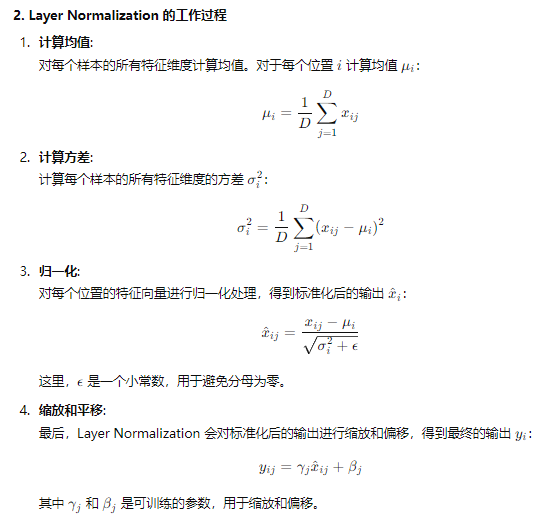

#### 3. **输出张量**

Layer Normalization 输出的张量形状与输入张量相同，即 `(B, S, D)`。经过归一化处理的输出具有零均值和单位方差，同时还保留了输入的原始信息，通过缩放和平移参数来控制输出的分布。

### 图示化过程

1. **输入**: 向量序列（形状 `(B, S, D)`）。
2. **均值计算**: 对每个位置计算均值 \( \mu_i \)。
3. **方差计算**: 计算方差 \( \sigma_i^2 \)。
4. **归一化**: 得到标准化后的输出 \( \hat{x}_i \)。
5. **缩放和平移**: 对标准化后的输出进行缩放和平移得到最终的输出 \( y_i \)。

### 总结

Layer Normalization 是一种重要的正则化技术，用于神经网络模型中，通过稳定各层输出的数值范围，防止梯度消失或爆炸，提升训练效率和模型泛化能力。通过图示可以更直观地理解它如何计算和应用到输入数据上。

In [6]:
class SeqEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, max_length, depth):
        super().__init__()
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)
        self.token_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=depth, mask_zero=True)
        self.add = tf.keras.layers.Add()

    def call(self, seq):
        seq = self.token_embedding(seq) # (batch, seq, depth)
        x = tf.range(tf.shape(seq)[1])  # (seq)
        x = x[tf.newaxis, :]  # (1, seq)
        x = self.pos_embedding(x)  # (1, seq, depth)
        return self.add([seq,x])
    
class CausalSelfAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()
    
    def call(self, x):
        attn = self.mha(query=x, value=x, use_causal_mask=True)  #【B，S，D】
        x = self.add([x, attn]) #【B，S，D】
        return self.layernorm(x)  #【B，S，D】

class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()
    
    def call(self, x,y ,**kwargs):
        attn, attention_scores = self.mha(query=x, value=y, return_attention_scores=True) # (B, S_query, D)  (B, H, S_query, S_value)
        self.last_attention_scores = attention_scores
        x = self.add([x, attn])
        return self.layernorm(x)

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, units, dropout=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(units=2*units, activation='relu'),
            tf.keras.layers.Dense(units=units),
            tf.keras.layers.Dropout(rate=dropout)
        ])
        self.layernorm =  tf.keras.layers.LayerNormalization()
        
    def call(self, x):
        x = x+self.seq(x)
        return self.layernorm(x)
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=1, dropout=0.1):
        super().__init__()
        self.self_attention = CausalSelfAttention(num_heads=num_heads, key_dim=units, dropout=dropout)
        self.cross_attention = CrossAttention(num_heads=num_heads, key_dim=units, dropout=dropout)
        self.ff = FeedForward(units=units, dropout=dropout)
        
    def call(self, inputs, training=False):
        in_seq, out_seq = inputs
        out_seq = self.self_attention(out_seq)
        out_seq = self.cross_attention(out_seq, in_seq)
        self.last_attention_scores = self.cross_attention.last_attention_scores
        out_seq = self.ff(out_seq)
        return out_seq

In [7]:
class TokenOutput(tf.keras.layers.Layer):
    def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
        super().__init__()
        self.dense = tf.keras.layers.Dense(units=tokenizer.vocabulary_size(), **kwargs)
        self.tokenizer = tokenizer
        self.banned_tokens = banned_tokens
        self.bias = None

    def adapt(self, ds):
        counts = collections.Counter()
        vocab_dict = {name: id for id, name in enumerate(self.tokenizer.get_vocabulary())}
        for tokens in tqdm.tqdm(ds):
            counts.update(tokens.numpy().flatten())
        counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
        counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())
        counts_arr = counts_arr[:]
        for token in self.banned_tokens:
            counts_arr[vocab_dict[token]] = 0
        total = counts_arr.sum()
        p = counts_arr / total
        p[counts_arr == 0] = 1.0
        log_p = np.log(p)  # log(1) == 0
        self.bias = log_p
        self.bias[counts_arr == 0] = -1e9

    def call(self, x):
        x = self.dense(x)
        return x + self.bias
    
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

938it [00:04, 188.84it/s]


In [8]:
output_layer.bias[:10]

array([-1.00000000e+09, -1.00000000e+09, -2.01532333e+00, -1.00000000e+09,
       -2.45960309e+00, -3.21569007e+00, -3.25744434e+00, -3.78060921e+00,
       -3.92826508e+00, -3.96288080e+00])

In [9]:
class Captioner(tf.keras.Model):
    def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1, units=256, max_length=50, num_heads=1, dropout=0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.word_to_index = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())
        self.index_to_word = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True)
        self.seq_embedding = SeqEmbedding(vocab_size=tokenizer.vocabulary_size(), depth=units, max_length=max_length)
        self.decoder_layers = [DecoderLayer(units=units, num_heads=num_heads, dropout=dropout) for _ in range(num_layers)]
        self.output_layer = output_layer
                             
    def call(self, inputs):
        image, txt = inputs
        if image.shape[-1] == 3:
            image = self.feature_extractor(image)
        image = einops.rearrange(image, 'b h w c -> b (h w) c')
        if txt.dtype == tf.string:
            txt = tokenizer(txt)
        txt = self.seq_embedding(txt)
        for de_layer in self.decoder_layers:
            txt = de_layer(inputs=(image, txt))
        txt = self.output_layer(txt)
        return txt
    
    def simple_gen(self, image, temperature=1):
        initial = self.word_to_index([['[START]']])
        img_features = self.feature_extractor(image[tf.newaxis, ...])
        tokens = initial
        for n in range(50):
            preds = self((img_features, tokens)).numpy()
            preds = preds[:, -1, :]
            if temperature == 0:
                next = tf.argmax(preds, axis=-1)[:, tf.newaxis]
            else:
                next = tf.random.categorical(preds/temperature, num_samples=1)
            tokens = tf.concat([tokens, next], axis=1)
            if next[0] == self.word_to_index('[END]'):
                break
        words = self.index_to_word(tokens[0, 1:-1])
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        return result.numpy().decode()

In [10]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout=0.5, num_layers=2, num_heads=2)

In [11]:
def masked_loss(labels, preds):  
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds) # 【B。S】
    mask = (labels != 0) & (loss < 1e8)  # 【B。S】
    mask = tf.cast(mask, loss.dtype) # 【B。S】
    loss = loss*mask # 【B。S】
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_acc(labels, preds):
    mask = tf.cast(labels!=0, tf.float32)
    preds = tf.argmax(preds, axis=-1)
    labels = tf.cast(labels, tf.int64)
    match = tf.cast(preds == labels, mask.dtype)
    acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
    return acc

class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self):
        image_url = 'https://tensorflow.org/images/surf.jpg'
        image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
        self.image = load_image(image_path)

    def on_epoch_end(self, epochs=None, logs=None):
        print()
        for t in (0.0, 0.5, 1.0):
            result = self.model.simple_gen(self.image, temperature=t)
            print(result)
        print()
callbacks = [ GenerateText(), 
             tf.keras.callbacks.EarlyStopping( patience=5, restore_best_weights=True)]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss=masked_loss, 
              metrics=[masked_acc])
history = model.fit(train_ds.repeat(),
                    steps_per_epoch=100,
                    validation_data=test_ds.repeat(),
                    validation_steps=20,
                    epochs=100,
                    callbacks=callbacks)

Epoch 1/100
 97/100 [============================>.] - ETA: 0s - loss: 5.0257 - masked_acc: 0.1954
a man in a a man in a a
a dog in a by a young in a
a dog

100/100 [==============================] - 7s 42ms/step - loss: 5.0134 - masked_acc: 0.1968 - val_loss: 4.6620 - val_masked_acc: 0.2365
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 4.6284 - masked_acc: 0.2539
a man in a red in the water
a little woman in a blue the ball
a sky tree cold tunnel couple a rope

100/100 [==============================] - 3s 33ms/step - loss: 4.6276 - masked_acc: 0.2541 - val_loss: 4.4225 - val_masked_acc: 0.2588
Epoch 3/100
 98/100 [============================>.] - ETA: 0s - loss: 4.3572 - masked_acc: 0.2778
a man in a red shirt is in the water
two people are in the beach
a camera is in the water

100/100 [==============================] - 3s 33ms/step - loss: 4.3545 - masked_acc: 0.2784 - val_loss: 4.1901 - val_masked_acc: 0.2843
Epoch 4/100
100/100 [=========================

Epoch 24/100
 99/100 [============================>.] - ETA: 0s - loss: 3.2107 - masked_acc: 0.3779
a man in a red shirt is swimming in the water
a man in a red shirt is surfing in the wave
a man in a guitar in air on a wave

100/100 [==============================] - 4s 36ms/step - loss: 3.2112 - masked_acc: 0.3778 - val_loss: 3.2264 - val_masked_acc: 0.3656
Epoch 25/100
 98/100 [============================>.] - ETA: 0s - loss: 3.1954 - masked_acc: 0.3835
a man in a red shirt is swimming in a wave
a surfer is riding a wave
a person rides their swim skis on a surfboard in someone into a pool

100/100 [==============================] - 3s 35ms/step - loss: 3.1947 - masked_acc: 0.3834 - val_loss: 3.1992 - val_masked_acc: 0.3676
Epoch 26/100
 99/100 [============================>.] - ETA: 0s - loss: 3.1733 - masked_acc: 0.3844
a man in a red shirt is swimming pool
the man is swimming in a wave
a man wearing is performing a under a wave

100/100 [==============================] - 3s 33ms/

Epoch 48/100
 98/100 [============================>.] - ETA: 0s - loss: 2.7886 - masked_acc: 0.4130
a man in a yellow kayak is surfing
a man wearing a yellow surfboard is riding a wave
a group of little blond floating through shallow water

100/100 [==============================] - 3s 34ms/step - loss: 2.7883 - masked_acc: 0.4132 - val_loss: 2.9287 - val_masked_acc: 0.3928
Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 2.7757 - masked_acc: 0.4155
a man in a red wetsuit is surfing
a man in a pink wetsuit is surfing
a man sits on large wave

100/100 [==============================] - 3s 32ms/step - loss: 2.7757 - masked_acc: 0.4155 - val_loss: 2.9881 - val_masked_acc: 0.3883
Epoch 50/100
 98/100 [============================>.] - ETA: 0s - loss: 2.7295 - masked_acc: 0.4192
a man in a red wetsuit is surfing
a man in a red wetsuit is surfing
a child is surfing with a wetsuit scuba on an outdoor bib

100/100 [==============================] - 3s 33ms/step - loss: 2

In [ ]:
# 2.8G-1.0G

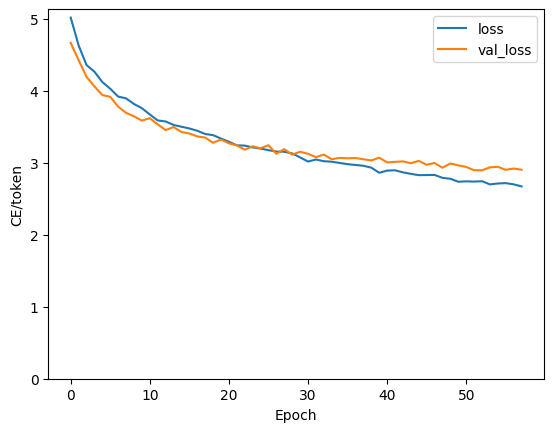

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('CE/token')
plt.legend()

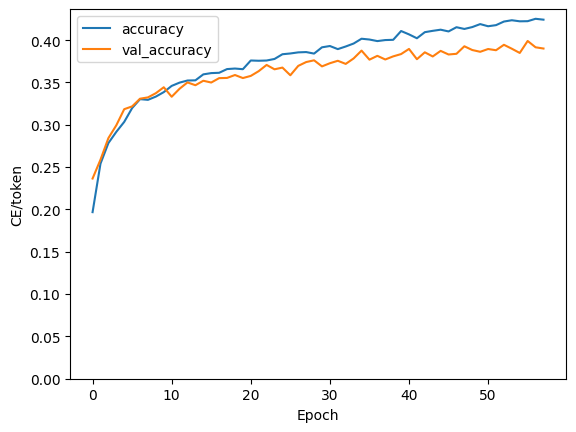

In [14]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('CE/token')
plt.legend()

In [21]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))
    len_result = len(str_tokens)
    titles = []
    for i in range(len_result):
        map = attention_map[i]
        grid_size = max(int(np.ceil(len_result / 2)), 2)
        ax = fig.add_subplot(3, grid_size, i + 1)
        titles.append(ax.set_title(str_tokens[i]))
        img = ax.imshow(image)
        ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),  clim=[0.0, np.max(map)])
    plt.tight_layout()


def run_and_show_attention(self, image, temperature=0.0):
    result_txt = self.simple_gen(image, temperature)
    str_tokens = result_txt.split()
    str_tokens.append('[END]')
    attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
    attention_maps = tf.concat(attention_maps, axis=0)
    attention_maps = einops.reduce( attention_maps, 'batch heads sequence (height width) -> sequence height width',  height=7, width=7, reduction='sum')
    plot_attention_maps(image / 255, str_tokens, attention_maps)
    t = plt.suptitle(result_txt)
    t.set_y(1.05)


In [ ]:
image_url = 'D:/anacondaProjects/tensorflow/flickr8k/Flicker8k_Dataset/219843860_332e5ca7d4.jpg'
image = load_image(image_url)
run_and_show_attention(model, image)